In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

data = pd.read_csv('../Merged_Data/data.csv')

In [9]:
##### Set the Plot Sheme #####
import tueplots
from tueplots import bundles

# this provides the color palette of Uni Tuebingen
from tueplots.constants.color import rgb
# e.g. as rgb.tue_blue, rgb.tue_red, etc.

# set plotting stylesheet
plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=2, usetex=False))

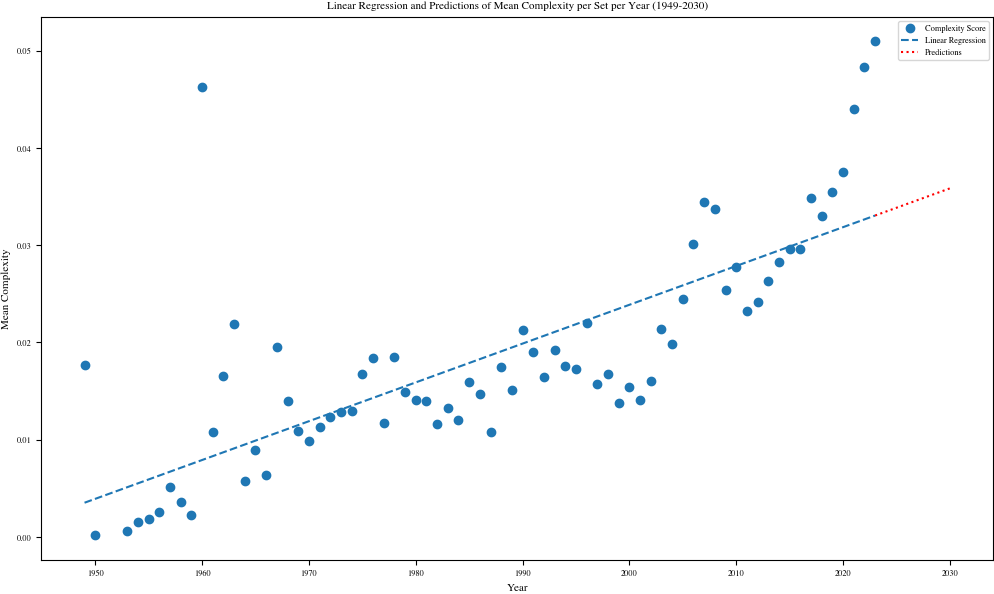

In [10]:
##### Plot mean complexity per set per year and a prediction until 2030#####

def linear_regression_complexity(df):
    
    mean_complexity_per_set_per_year = df.groupby('year')['complexity_score'].mean().reset_index(name='complexity_score')

    # create the plot
    plt.figure(figsize=(10, 6))
    x = mean_complexity_per_set_per_year['year'].values.reshape(-1, 1)
    y = mean_complexity_per_set_per_year['complexity_score'].values
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    plt.scatter(x, y, label='Complexity Score')
    plt.plot(x, y_pred, linestyle='--', label='Linear Regression')

    # make predictions until 2030
    x_future = np.arange(2023, 2031).reshape(-1, 1)
    y_future_pred = model.predict(x_future)
    plt.plot(x_future, y_future_pred, linestyle=':', color='red', label='Predictions')

    # add title and labels
    plt.title('Linear Regression and Predictions of Mean Complexity per Set per Year (1949-2030)')
    plt.xlabel('Year')
    plt.ylabel('Mean Complexity')
    plt.legend()

    # show the plot
    plt.show()

# call the function
linear_regression_complexity(data)